In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, default_collate
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
torch.manual_seed(0)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import time

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

In [3]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
#transform = transforms.ToTensor()

# obtain training indices that will be used for validation
num_train = len(mnist_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(mnist_trainset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers,)
valid_loader = DataLoader(mnist_trainset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(mnist_testset, batch_size=1, 
    num_workers=num_workers)

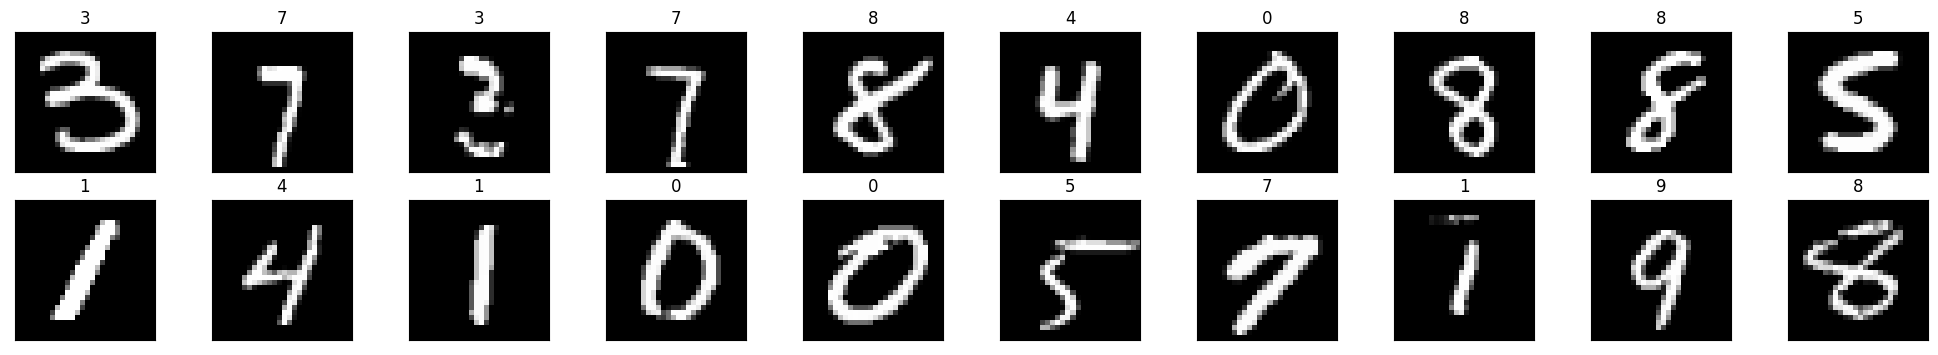

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

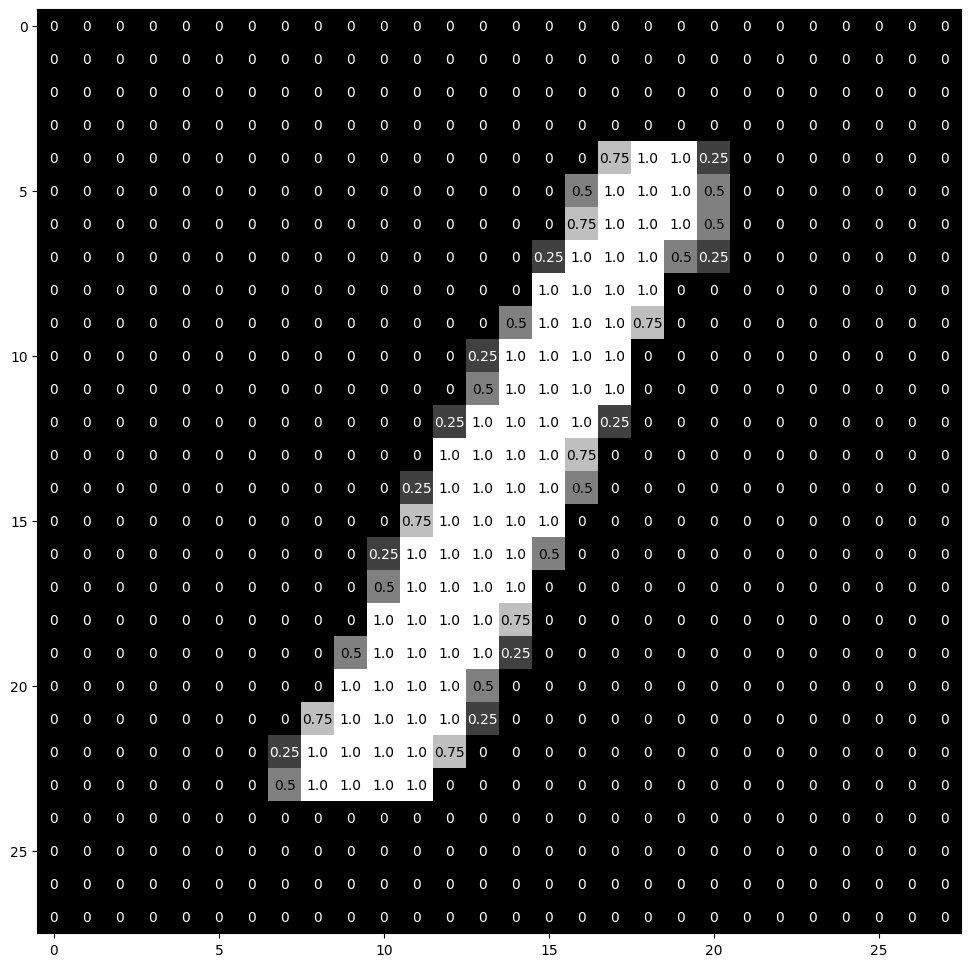

In [6]:
img = np.squeeze(images[10])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [7]:
class myNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.0, batch_norm=False):
        """Initialize the model with the input_size, output_size, and hidden_layers, and whether to use dropout or batch normalization.

        Args:
            input_size (int): The size of the input
            output_size (int): The size of the output
            hidden_layers (list): A list of the hidden layer sizes
            drop_p (float, optional): The dropout probability. Defaults to 0.0.
            batch_norm (bool, optional): Whether to use batch normalization. Defaults to False.
        """
        
        super(myNN, self).__init__()
        
        self.input_size = input_size
        
        self.hidden_layer_sizes = hidden_layers
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, self.hidden_layer_sizes[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(self.hidden_layer_sizes[:-1], self.hidden_layer_sizes[1:])
        
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        # Add the output layer
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout_p = drop_p
        self.dropout = nn.Dropout(p=self.dropout_p)
        
        self.batch_norm = batch_norm
        
        if self.batch_norm:
            self.bn_layers = nn.ModuleList([nn.BatchNorm1d(h) for h in hidden_layers])
            
        # Add attribute to store train time
        self.train_time = 0
        
        # Add attribute to store loss function
        self.loss_fn = None
        
        # Add attribute to store optimizer
        self.optimizer = None
        
        # Add attribute to store scheduler
        self.scheduler = None
        
        # Add attribute to store train accuracy
        self.train_accuracy = None
        
        # Add attribute to store test accuracy
        self.test_accuracy = None
        
    def forward(self, x):
        # Flatten the image
        x = x.view(-1, self.input_size)
        
        # Forward through each hidden layer with dropout and activation
        for i, linear in enumerate(self.hidden_layers):
            x = self.dropout(x)            
            x = linear(x)
            if self.batch_norm:
                x = self.bn_layers[i](x)
            x = F.relu(x)

        # Forward through the output layer
        x = self.output(x)
        
        return x

In [8]:
def train_model(model, n_epochs, loss_fn, optimizer, scheduler=None):
    """Trains a model and returns the training and validation losses."""
    
    model.loss_fn = loss_fn
    model.optimizer = optimizer
    model.scheduler = scheduler
    
    # store start time
    start_time = time.time()
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    # initialize lists to track losses
    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = loss_fn(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            # adjust learning rate
            if scheduler:
                scheduler.step()
            
  
        # validate the model #

        model.eval()
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = loss_fn(output, target)
            # update running validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        
        # store loss values
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            valid_loss
            ))
        
        if scheduler:
            print(f'Learning rate at end of epoch {epoch+1}: \t{scheduler.get_last_lr()[0]:.6f}')
        
        # implement early stopping with patience
        if valid_loss <= valid_loss_min:
            valid_loss_min = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == 5:
                print(f'Early stopping! Total epochs: {epoch+1}.')
                break
    
    # print total training time
    total_time = (time.time() - start_time)/60
    model.train_time = total_time
    print(f'Total training time: {total_time:.2f} minutes')
            
    return train_losses, valid_losses

In [9]:
def predict(model, dataloader):
    """Make predictions on a dataset using a trained model.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Dataset to make predictions on.
    
    Returns:
        prediction_list (np.array): List of predictions.
        truth_list (np.array): List of ground truth values.
    """
    model.eval()
    prediction_list = []
    truth_list = []
    for batch, labels in (dataloader):
        outputs = model(batch)
        _, predicted = torch.max(outputs.data, 1) 
        prediction_list.append(predicted.cpu())
        truth_list.append(labels.cpu())
    prediction_list = np.concatenate(prediction_list)
    truth_list = np.concatenate(truth_list)
    return prediction_list, truth_list

In [10]:
def plot_loss(train_losses, valid_losses):
    """Plot training and validation losses."""
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

In [11]:
def model_accuracy(model, dataloader, dataset=None, print_accuracy=True):
    """Calculates the accuracy of a model on a given dataset.
    
    Args:
        model (nn.Module): The model to be evaluated.
        dataloader (DataLoader): The DataLoader for the dataset to be evaluated.
        dataset (str): The name of the dataset to be evaluated (train or test). 
            Default: None.
        print_accuracy (bool): Whether to print the accuracy. If not, will return the
            accuracy Default: True.
    """
    prediction_list, truth_list = predict(model, dataloader)
    accuracy = accuracy_score(truth_list, prediction_list)
    
    if dataset == 'test':
        model.test_accuracy = accuracy
    elif dataset == 'train':
        model.train_accuracy = accuracy
    else:
        pass
    
    if print_accuracy:
        print(f'{dataset.capitalize()} Accuracy: {accuracy*100:.2f}%')
    else:
        return accuracy

In [12]:
def plot_confusion_matrix(model, dataloader, model_num):
    """Plots the confusion matrix for a given model and dataloader.
    
    Args:
        model (nn.Module): The model to be evaluated.
        dataloader (DataLoader): The dataloader to be used for evaluation.
        model_num (int): The model number to be used in the title.
    """
    prediction_list, truth_list = predict(model, dataloader)
    accuracy = model_accuracy(model, dataloader, print_accuracy=False)
    cm = confusion_matrix(truth_list, prediction_list)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(f'Model {model_num} Accuracy: {accuracy:.4f}')
    plt.show()

In [13]:
def save_model_info(model, model_num):
    """Saves model information to a dictionary."""
    model_info = {}
    model_info['model_num'] = model_num
    model_info['hidden_layer_sizes'] = model.hidden_layer_sizes
    model_info['dropout_p'] = model.dropout_p
    model_info['batch_norm'] = model.batch_norm
    model_info['train_time_mins'] = model.train_time
    model_info['loss_fn'] = model.loss_fn
    model_info['optimizer'] = model.optimizer
    model_info['scheduler'] = model.scheduler
    model_info['train_accuracy'] = model.train_accuracy
    model_info['test_accuracy'] = model.test_accuracy
    return model_info

In [14]:
models_info = pd.DataFrame(columns=['model_num', 'hidden_layer_sizes', 'dropout_p', 'batch_norm', 'train_time_mins', 'loss_fn', 'optimizer', 'scheduler', 'test_accuracy'])

## Trial 1
2 hidden layers (128, 128), 0.2 dropout, no batchnorm  
cross entropy loss, SGD (0.01 lr no schedule)

In [15]:
# initialize the NN
model1 = myNN(input_size=784, output_size=10, hidden_layers=[128, 128], drop_p=0.2, batch_norm=False)
print(model1)

# specify loss function (categorical cross-entropy)
loss_fn1 = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [16]:
train_losses1, valid_losses1 = train_model(model1, 50, loss_fn1, optimizer1)

Epoch: 1 	Training Loss: 1.103629 	Validation Loss: 0.110280
Epoch: 2 	Training Loss: 0.417456 	Validation Loss: 0.073450
Epoch: 3 	Training Loss: 0.330684 	Validation Loss: 0.060921
Epoch: 4 	Training Loss: 0.284984 	Validation Loss: 0.052918
Epoch: 5 	Training Loss: 0.256088 	Validation Loss: 0.047443
Epoch: 6 	Training Loss: 0.232290 	Validation Loss: 0.042982
Epoch: 7 	Training Loss: 0.212181 	Validation Loss: 0.038846
Epoch: 8 	Training Loss: 0.195132 	Validation Loss: 0.035584
Epoch: 9 	Training Loss: 0.180206 	Validation Loss: 0.032857
Epoch: 10 	Training Loss: 0.168743 	Validation Loss: 0.030580
Epoch: 11 	Training Loss: 0.158152 	Validation Loss: 0.028925
Epoch: 12 	Training Loss: 0.148436 	Validation Loss: 0.027228
Epoch: 13 	Training Loss: 0.141657 	Validation Loss: 0.025714
Epoch: 14 	Training Loss: 0.134703 	Validation Loss: 0.024625
Epoch: 15 	Training Loss: 0.129741 	Validation Loss: 0.023456
Epoch: 16 	Training Loss: 0.123600 	Validation Loss: 0.022979
Epoch: 17 	Traini

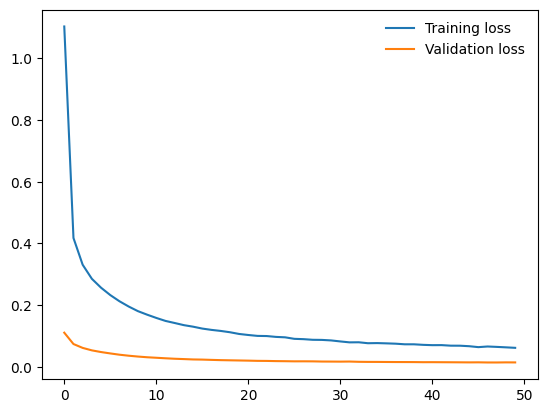

In [17]:
plot_loss(train_losses1, valid_losses1)

In [18]:
#Train Accuracy
model_accuracy(model1, train_loader, dataset='train')

Train Accuracy: 99.05%


In [19]:
#Test Accuracy
model_accuracy(model1, test_loader, dataset='test')

Test Accuracy: 97.92%


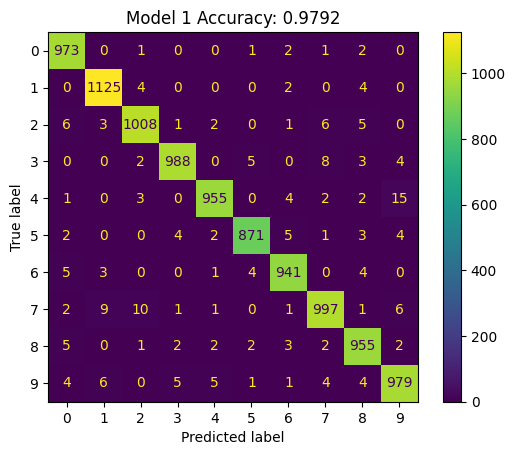

In [20]:
plot_confusion_matrix(model1, test_loader, 1)

In [21]:
model1_info = save_model_info(model1, 1)
models_info = models_info.append(model1_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\4048060514.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model1_info, ignore_index=True)


## Trial 2
2 hidden layers (128, 128), 0.2 dropout, no batchnorm  
cross entropy loss, SGD (0.01 lr with step LR schedule)

In [22]:
# initialize the NN
model2 = myNN(input_size=784, output_size=10, hidden_layers=[128, 128], drop_p=0.2, batch_norm=False)
print(model2)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

# specify scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_loader)*10, gamma=0.1)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [23]:
train_losses2, valid_losses2 = train_model(model2, 50, loss_fn, optimizer, scheduler)

Epoch: 1 	Training Loss: 1.096032 	Validation Loss: 0.105717
Learning rate at end of epoch 1: 	0.010000
Epoch: 2 	Training Loss: 0.411157 	Validation Loss: 0.072472
Learning rate at end of epoch 2: 	0.010000
Epoch: 3 	Training Loss: 0.330848 	Validation Loss: 0.061590
Learning rate at end of epoch 3: 	0.010000
Epoch: 4 	Training Loss: 0.287581 	Validation Loss: 0.053498
Learning rate at end of epoch 4: 	0.010000
Epoch: 5 	Training Loss: 0.257262 	Validation Loss: 0.047632
Learning rate at end of epoch 5: 	0.010000
Epoch: 6 	Training Loss: 0.233134 	Validation Loss: 0.042609
Learning rate at end of epoch 6: 	0.010000
Epoch: 7 	Training Loss: 0.215436 	Validation Loss: 0.038492
Learning rate at end of epoch 7: 	0.010000
Epoch: 8 	Training Loss: 0.196456 	Validation Loss: 0.036107
Learning rate at end of epoch 8: 	0.010000
Epoch: 9 	Training Loss: 0.184494 	Validation Loss: 0.032714
Learning rate at end of epoch 9: 	0.010000
Epoch: 10 	Training Loss: 0.170634 	Validation Loss: 0.030670
Le

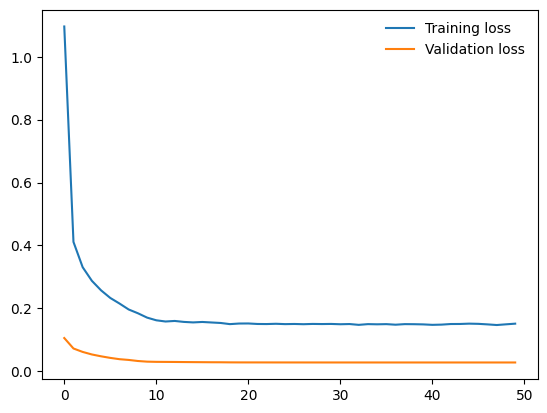

In [24]:
plot_loss(train_losses2, valid_losses2)

In [25]:
#Train Accuracy
model_accuracy(model2, train_loader, dataset='train')

Train Accuracy: 96.12%


In [26]:
#Test Accuracy
model_accuracy(model2, test_loader, dataset='test')

Test Accuracy: 95.88%


Model did not converge since learning rate dropped early.

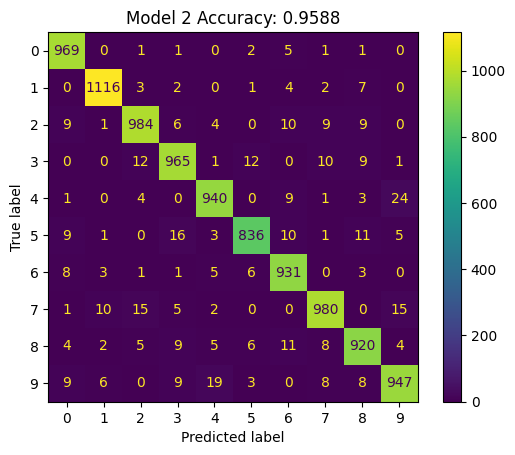

In [27]:
plot_confusion_matrix(model2, test_loader, 2)

In [28]:
model2_info = save_model_info(model2, 2)
models_info = models_info.append(model2_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\583907823.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model2_info, ignore_index=True)
C:\Users\thele\AppData\Local\Temp\ipykernel_41788\583907823.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  models_info = models_info.append(model2_info, ignore_index=True)


## Trial 3
2 hidden layers (128, 128), 0.2 dropout, no batchnorm  
cross entropy loss, SGD (0.01 lr with one-cycle LR schedule)

In [29]:
# initialize the NN
model3 = myNN(input_size=784, output_size=10, hidden_layers=[128, 128], drop_p=0.2, batch_norm=False)
print(model3)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.SGD(model3.parameters(), lr=0.01)

# specify scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [30]:
train_losses3, valid_losses3 = train_model(model3, 50, loss_fn, optimizer, scheduler)

Epoch: 1 	Training Loss: 1.262762 	Validation Loss: 0.121969
Learning rate at end of epoch 1: 	0.000505
Epoch: 2 	Training Loss: 0.437357 	Validation Loss: 0.072903
Learning rate at end of epoch 2: 	0.000815
Epoch: 3 	Training Loss: 0.320658 	Validation Loss: 0.055459
Learning rate at end of epoch 3: 	0.001317
Epoch: 4 	Training Loss: 0.251143 	Validation Loss: 0.042480
Learning rate at end of epoch 4: 	0.001988
Epoch: 5 	Training Loss: 0.199407 	Validation Loss: 0.033781
Learning rate at end of epoch 5: 	0.002800
Epoch: 6 	Training Loss: 0.164290 	Validation Loss: 0.026839
Learning rate at end of epoch 6: 	0.003717
Epoch: 7 	Training Loss: 0.140755 	Validation Loss: 0.023884
Learning rate at end of epoch 7: 	0.004699
Epoch: 8 	Training Loss: 0.123441 	Validation Loss: 0.020259
Learning rate at end of epoch 8: 	0.005702
Epoch: 9 	Training Loss: 0.114171 	Validation Loss: 0.018528
Learning rate at end of epoch 9: 	0.006684
Epoch: 10 	Training Loss: 0.104357 	Validation Loss: 0.018006
Le

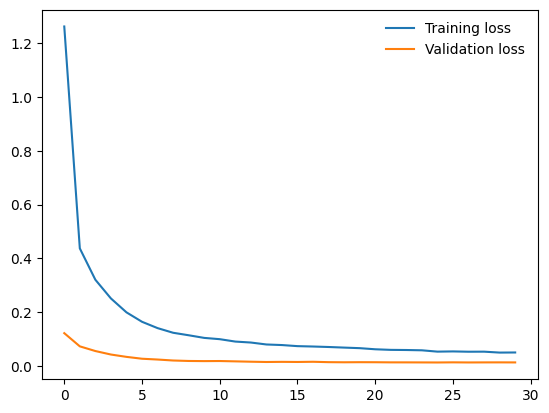

In [31]:
plot_loss(train_losses3, valid_losses3)

In [32]:
#Train Accuracy
model_accuracy(model3, train_loader, dataset='train')

Train Accuracy: 99.51%


In [33]:
#Test Accuracy
model_accuracy(model3, test_loader, dataset='test')

Test Accuracy: 98.08%


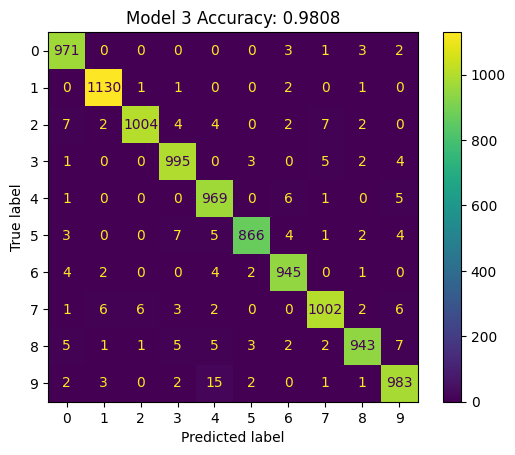

In [34]:
plot_confusion_matrix(model3, test_loader, 3)

In [35]:
model3_info = save_model_info(model3, 3)
models_info = models_info.append(model3_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\70929025.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model3_info, ignore_index=True)
C:\Users\thele\AppData\Local\Temp\ipykernel_41788\70929025.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  models_info = models_info.append(model3_info, ignore_index=True)


## Trial 4
2 hidden layers (128, 128), no dropout, batchnorm  
cross entropy loss, SGD (0.01 lr with One-cycle LR schedule)

In [36]:
# initialize the NN
model4 = myNN(input_size=784, output_size=10, hidden_layers=[128, 128], drop_p=0.0, batch_norm=True)
print(model4)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.SGD(model4.parameters(), lr=0.01)

# specify scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (bn_layers): ModuleList(
    (0-1): 2 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [37]:
train_losses4, valid_losses4 = train_model(model4, 50, loss_fn, optimizer, scheduler)

Epoch: 1 	Training Loss: 0.398575 	Validation Loss: 0.039617
Learning rate at end of epoch 1: 	0.000505
Epoch: 2 	Training Loss: 0.160499 	Validation Loss: 0.025906
Learning rate at end of epoch 2: 	0.000815
Epoch: 3 	Training Loss: 0.111540 	Validation Loss: 0.020326
Learning rate at end of epoch 3: 	0.001317
Epoch: 4 	Training Loss: 0.088926 	Validation Loss: 0.018989
Learning rate at end of epoch 4: 	0.001988
Epoch: 5 	Training Loss: 0.074596 	Validation Loss: 0.016654
Learning rate at end of epoch 5: 	0.002800
Epoch: 6 	Training Loss: 0.062023 	Validation Loss: 0.015805
Learning rate at end of epoch 6: 	0.003717
Epoch: 7 	Training Loss: 0.056008 	Validation Loss: 0.014212
Learning rate at end of epoch 7: 	0.004699
Epoch: 8 	Training Loss: 0.049716 	Validation Loss: 0.014785
Learning rate at end of epoch 8: 	0.005702
Epoch: 9 	Training Loss: 0.043010 	Validation Loss: 0.013334
Learning rate at end of epoch 9: 	0.006684
Epoch: 10 	Training Loss: 0.038834 	Validation Loss: 0.014172
Le

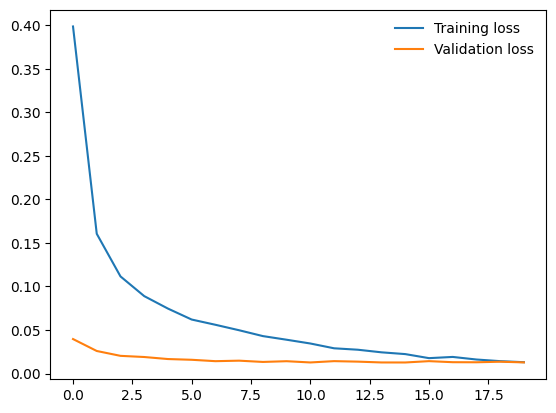

In [38]:
plot_loss(train_losses4, valid_losses4)

In [39]:
#Train Accuracy
model_accuracy(model4, train_loader, dataset='train')

Train Accuracy: 99.93%


In [40]:
#Test Accuracy
model_accuracy(model4, test_loader, dataset='test')

Test Accuracy: 98.07%


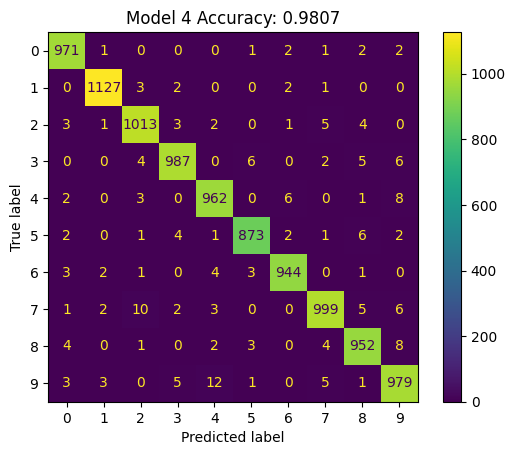

In [41]:
plot_confusion_matrix(model4, test_loader, 4)

In [42]:
model4_info = save_model_info(model4, 4)
models_info = models_info.append(model4_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\2204533702.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model4_info, ignore_index=True)
C:\Users\thele\AppData\Local\Temp\ipykernel_41788\2204533702.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  models_info = models_info.append(model4_info, ignore_index=True)


## Trial 5
3 hidden layers (128, 128, 64), 0.2 dropout, no batchnorm  
cross entropy loss, SGD (0.01 lr with One-cycle LR schedule)

In [43]:
# initialize the NN
model5 = myNN(input_size=784, output_size=10, hidden_layers=[128, 128, 64], drop_p=0.2, batch_norm=False)
print(model5)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.SGD(model5.parameters(), lr=0.01)

# specify scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [44]:
train_losses5, valid_losses5 = train_model(model5, 50, loss_fn, optimizer, scheduler)

Epoch: 1 	Training Loss: 1.781900 	Validation Loss: 0.368309
Learning rate at end of epoch 1: 	0.000505
Epoch: 2 	Training Loss: 0.790089 	Validation Loss: 0.095474
Learning rate at end of epoch 2: 	0.000815
Epoch: 3 	Training Loss: 0.393699 	Validation Loss: 0.058399
Learning rate at end of epoch 3: 	0.001317
Epoch: 4 	Training Loss: 0.274710 	Validation Loss: 0.039107
Learning rate at end of epoch 4: 	0.001988
Epoch: 5 	Training Loss: 0.206878 	Validation Loss: 0.032493
Learning rate at end of epoch 5: 	0.002800
Epoch: 6 	Training Loss: 0.170565 	Validation Loss: 0.026509
Learning rate at end of epoch 6: 	0.003717
Epoch: 7 	Training Loss: 0.148212 	Validation Loss: 0.022649
Learning rate at end of epoch 7: 	0.004699
Epoch: 8 	Training Loss: 0.131556 	Validation Loss: 0.020609
Learning rate at end of epoch 8: 	0.005702
Epoch: 9 	Training Loss: 0.122118 	Validation Loss: 0.019926
Learning rate at end of epoch 9: 	0.006684
Epoch: 10 	Training Loss: 0.112749 	Validation Loss: 0.018960
Le

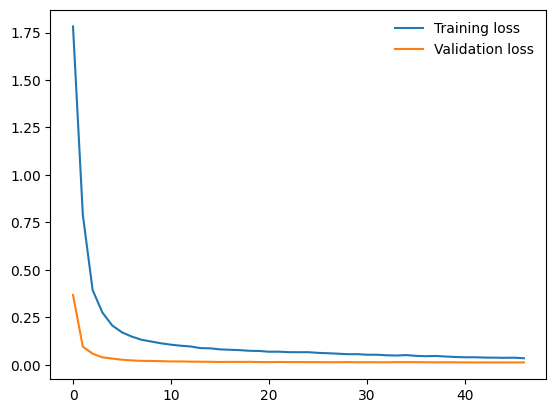

In [45]:
plot_loss(train_losses5, valid_losses5)

In [46]:
#Train Accuracy
model_accuracy(model5, train_loader, dataset='train')

Train Accuracy: 99.82%


In [47]:
#Test Accuracy
model_accuracy(model5, test_loader, dataset='test')

Test Accuracy: 98.36%


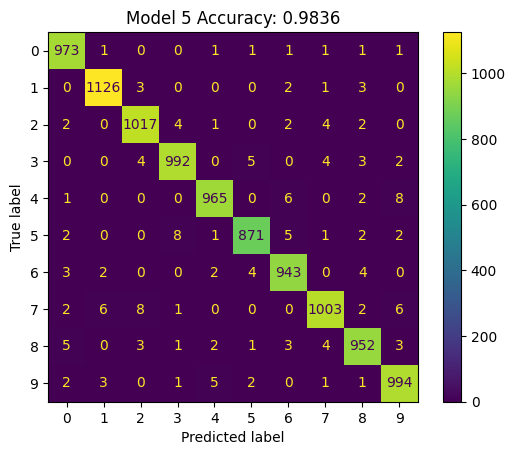

In [48]:
plot_confusion_matrix(model5, test_loader, 5)

In [49]:
model5_info = save_model_info(model5, 5)
models_info = models_info.append(model5_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\2734901850.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model5_info, ignore_index=True)
C:\Users\thele\AppData\Local\Temp\ipykernel_41788\2734901850.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  models_info = models_info.append(model5_info, ignore_index=True)


## Trial 6
2 hidden layers (512, 512), 0.2 dropout, no batchnorm  
cross entropy loss, SGD (0.01 lr with One-cycle LR schedule)

In [50]:
# initialize the NN
model6 = myNN(input_size=784, output_size=10, hidden_layers=[512, 512], drop_p=0.2, batch_norm=False)
print(model6)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.SGD(model6.parameters(), lr=0.01)

# specify scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [51]:
train_losses6, valid_losses6 = train_model(model6, 50, loss_fn, optimizer, scheduler)

Epoch: 1 	Training Loss: 1.179246 	Validation Loss: 0.111154
Learning rate at end of epoch 1: 	0.000505
Epoch: 2 	Training Loss: 0.384633 	Validation Loss: 0.068837
Learning rate at end of epoch 2: 	0.000815
Epoch: 3 	Training Loss: 0.293185 	Validation Loss: 0.053955
Learning rate at end of epoch 3: 	0.001317
Epoch: 4 	Training Loss: 0.230138 	Validation Loss: 0.040582
Learning rate at end of epoch 4: 	0.001988
Epoch: 5 	Training Loss: 0.179331 	Validation Loss: 0.031158
Learning rate at end of epoch 5: 	0.002800
Epoch: 6 	Training Loss: 0.139738 	Validation Loss: 0.026406
Learning rate at end of epoch 6: 	0.003717
Epoch: 7 	Training Loss: 0.114361 	Validation Loss: 0.024470
Learning rate at end of epoch 7: 	0.004699
Epoch: 8 	Training Loss: 0.096833 	Validation Loss: 0.018608
Learning rate at end of epoch 8: 	0.005702
Epoch: 9 	Training Loss: 0.086719 	Validation Loss: 0.016553
Learning rate at end of epoch 9: 	0.006684
Epoch: 10 	Training Loss: 0.078012 	Validation Loss: 0.015715
Le

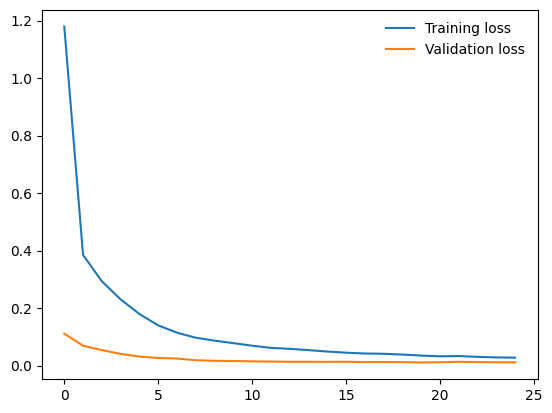

In [52]:
plot_loss(train_losses6, valid_losses6)

In [53]:
#Train Accuracy
model_accuracy(model6, train_loader, dataset='train')

Train Accuracy: 99.80%


In [54]:
#Test Accuracy
model_accuracy(model6, test_loader, dataset='test')

Test Accuracy: 98.46%


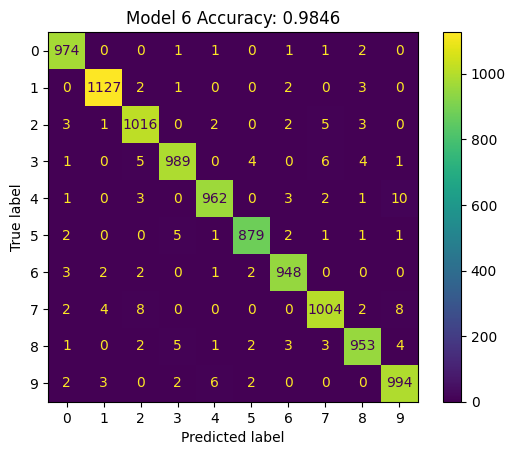

In [55]:
plot_confusion_matrix(model6, test_loader, 6)

In [56]:
model6_info = save_model_info(model6, 6)
models_info = models_info.append(model6_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\1594982369.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model6_info, ignore_index=True)
C:\Users\thele\AppData\Local\Temp\ipykernel_41788\1594982369.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  models_info = models_info.append(model6_info, ignore_index=True)


## Trial 7
5 hidden layers (128, 128, 128, 64, 64), 0.2 dropout, no batchnorm  
cross entropy loss, SGD (0.01 lr with One-cycle LR schedule)

In [57]:
# initialize the NN
model7 = myNN(input_size=784, output_size=10, hidden_layers=[128, 128, 128, 64, 64], drop_p=0.2, batch_norm=False)
print(model7)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.SGD(model7.parameters(), lr=0.01)

# specify scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [58]:
train_losses7, valid_losses7 = train_model(model7, 50, loss_fn, optimizer, scheduler)

Epoch: 1 	Training Loss: 1.841687 	Validation Loss: 0.459909
Learning rate at end of epoch 1: 	0.000505
Epoch: 2 	Training Loss: 1.836753 	Validation Loss: 0.456231
Learning rate at end of epoch 2: 	0.000815
Epoch: 3 	Training Loss: 1.488384 	Validation Loss: 0.198215
Learning rate at end of epoch 3: 	0.001317
Epoch: 4 	Training Loss: 0.616507 	Validation Loss: 0.072866
Learning rate at end of epoch 4: 	0.001988
Epoch: 5 	Training Loss: 0.326584 	Validation Loss: 0.043810
Learning rate at end of epoch 5: 	0.002800
Epoch: 6 	Training Loss: 0.232232 	Validation Loss: 0.031163
Learning rate at end of epoch 6: 	0.003717
Epoch: 7 	Training Loss: 0.189582 	Validation Loss: 0.028050
Learning rate at end of epoch 7: 	0.004699
Epoch: 8 	Training Loss: 0.166003 	Validation Loss: 0.025965
Learning rate at end of epoch 8: 	0.005702
Epoch: 9 	Training Loss: 0.147105 	Validation Loss: 0.024252
Learning rate at end of epoch 9: 	0.006684
Epoch: 10 	Training Loss: 0.140783 	Validation Loss: 0.021796
Le

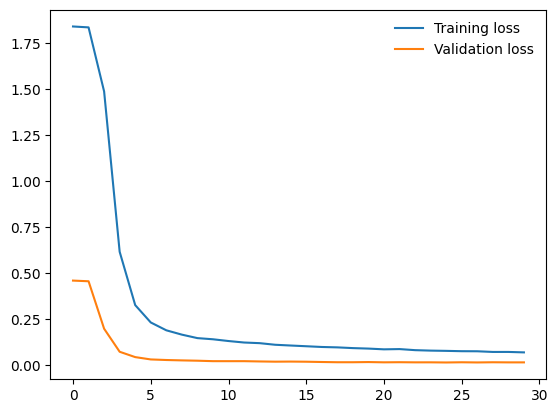

In [59]:
plot_loss(train_losses7, valid_losses7)

In [60]:
#Train Accuracy
model_accuracy(model7, train_loader, dataset='train')

Train Accuracy: 99.26%


In [61]:
#Test Accuracy
model_accuracy(model7, test_loader, dataset='test')

Test Accuracy: 97.92%


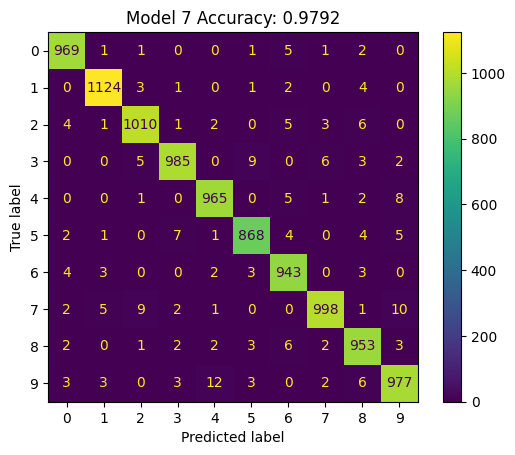

In [62]:
plot_confusion_matrix(model7, test_loader, 7)

In [63]:
model7_info = save_model_info(model7, 7)
models_info = models_info.append(model7_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\1108592972.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model7_info, ignore_index=True)
C:\Users\thele\AppData\Local\Temp\ipykernel_41788\1108592972.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  models_info = models_info.append(model7_info, ignore_index=True)


## Trial 8
2 hidden layers (512, 512), 0.5 dropout, no batchnorm  
cross entropy loss, SGD (0.01 lr with One-cycle LR schedule)

In [64]:
# initialize the NN
model8 = myNN(input_size=784, output_size=10, hidden_layers=[512, 512], drop_p=0.5, batch_norm=False)
print(model8)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.SGD(model8.parameters(), lr=0.01)

# specify scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [65]:
train_losses8, valid_losses8 = train_model(model8, 50, loss_fn, optimizer, scheduler)

Epoch: 1 	Training Loss: 1.322263 	Validation Loss: 0.124625
Learning rate at end of epoch 1: 	0.000505
Epoch: 2 	Training Loss: 0.521461 	Validation Loss: 0.075100
Learning rate at end of epoch 2: 	0.000815
Epoch: 3 	Training Loss: 0.411033 	Validation Loss: 0.058570
Learning rate at end of epoch 3: 	0.001317
Epoch: 4 	Training Loss: 0.332770 	Validation Loss: 0.043658
Learning rate at end of epoch 4: 	0.001988
Epoch: 5 	Training Loss: 0.276449 	Validation Loss: 0.035286
Learning rate at end of epoch 5: 	0.002800
Epoch: 6 	Training Loss: 0.236653 	Validation Loss: 0.029200
Learning rate at end of epoch 6: 	0.003717
Epoch: 7 	Training Loss: 0.211276 	Validation Loss: 0.025736
Learning rate at end of epoch 7: 	0.004699
Epoch: 8 	Training Loss: 0.194273 	Validation Loss: 0.023272
Learning rate at end of epoch 8: 	0.005702
Epoch: 9 	Training Loss: 0.180161 	Validation Loss: 0.022604
Learning rate at end of epoch 9: 	0.006684
Epoch: 10 	Training Loss: 0.172982 	Validation Loss: 0.018728
Le

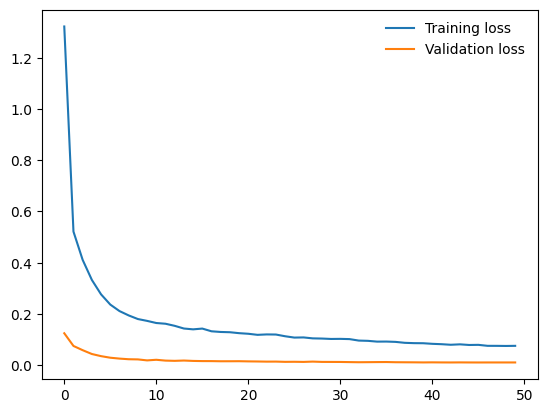

In [66]:
plot_loss(train_losses8, valid_losses8)

In [67]:
#Train Accuracy
model_accuracy(model8, train_loader, dataset='train')

Train Accuracy: 99.29%


In [68]:
#Test Accuracy
model_accuracy(model8, test_loader, dataset='test')

Test Accuracy: 98.24%


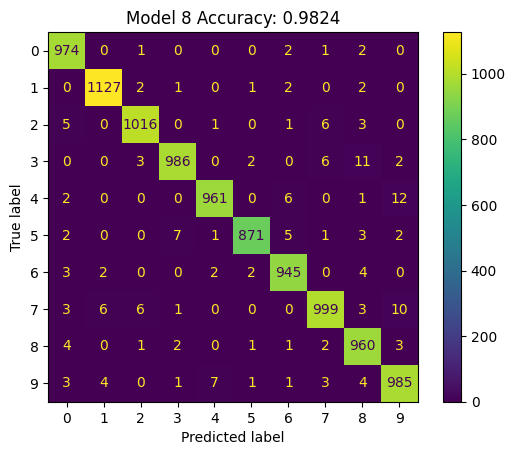

In [69]:
plot_confusion_matrix(model8, test_loader, 8)

In [70]:
model8_info = save_model_info(model8, 8)
models_info = models_info.append(model8_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\2449474200.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model8_info, ignore_index=True)
C:\Users\thele\AppData\Local\Temp\ipykernel_41788\2449474200.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  models_info = models_info.append(model8_info, ignore_index=True)


## Trial 9
2 hidden layers (512, 512), 0.2 dropout, no batchnorm  
cross entropy loss, SGD (0.01 lr with One-cycle LR schedule), L2 weight decay & momentum

In [71]:
# initialize the NN
model9 = myNN(input_size=784, output_size=10, hidden_layers=[512, 512], drop_p=0.2, batch_norm=False)
print(model9)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.SGD(model9.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

# specify scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [72]:
train_losses9, valid_losses9 = train_model(model9, 50, loss_fn, optimizer, scheduler)

Epoch: 1 	Training Loss: 1.185467 	Validation Loss: 0.113605
Learning rate at end of epoch 1: 	0.000505
Epoch: 2 	Training Loss: 0.398120 	Validation Loss: 0.073244
Learning rate at end of epoch 2: 	0.000815
Epoch: 3 	Training Loss: 0.312202 	Validation Loss: 0.060687
Learning rate at end of epoch 3: 	0.001317
Epoch: 4 	Training Loss: 0.264002 	Validation Loss: 0.051000
Learning rate at end of epoch 4: 	0.001988
Epoch: 5 	Training Loss: 0.221635 	Validation Loss: 0.041747
Learning rate at end of epoch 5: 	0.002800
Epoch: 6 	Training Loss: 0.192263 	Validation Loss: 0.037325
Learning rate at end of epoch 6: 	0.003717
Epoch: 7 	Training Loss: 0.174611 	Validation Loss: 0.034603
Learning rate at end of epoch 7: 	0.004699
Epoch: 8 	Training Loss: 0.163057 	Validation Loss: 0.032165
Learning rate at end of epoch 8: 	0.005702
Epoch: 9 	Training Loss: 0.155533 	Validation Loss: 0.031325
Learning rate at end of epoch 9: 	0.006684
Epoch: 10 	Training Loss: 0.149351 	Validation Loss: 0.030179
Le

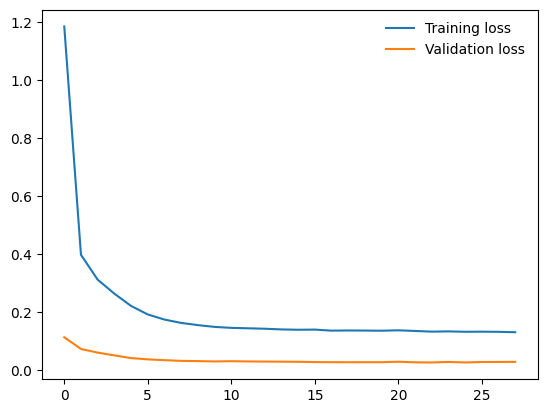

In [73]:
plot_loss(train_losses9, valid_losses9)

In [74]:
#Train Accuracy
model_accuracy(model9, train_loader, dataset='train')

Train Accuracy: 96.43%


In [75]:
#Test Accuracy
model_accuracy(model9, test_loader, dataset='test')

Test Accuracy: 96.15%


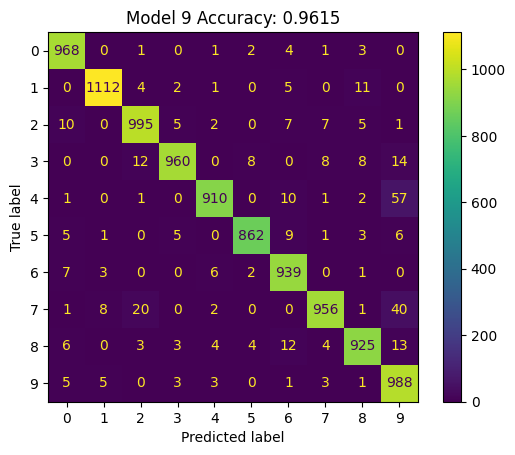

In [76]:
plot_confusion_matrix(model9, test_loader, 9)

In [77]:
model9_info = save_model_info(model9, 9)
models_info = models_info.append(model9_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\1145817184.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model9_info, ignore_index=True)
C:\Users\thele\AppData\Local\Temp\ipykernel_41788\1145817184.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  models_info = models_info.append(model9_info, ignore_index=True)


## Trial 10
2 hidden layers (512, 512), 0.2 dropout, no batchnorm  
cross entropy loss, Adam (0.01 lr with One-cycle LR schedule)

In [78]:
# initialize the NN
model10 = myNN(input_size=784, output_size=10, hidden_layers=[512, 512], drop_p=0.2, batch_norm=False)
print(model10)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.Adam(model10.parameters(), lr=0.01)

# specify scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

myNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [79]:
train_losses10, valid_losses10 = train_model(model10, 50, loss_fn, optimizer, scheduler)

Epoch: 1 	Training Loss: 0.273363 	Validation Loss: 0.028338
Learning rate at end of epoch 1: 	0.000505
Epoch: 2 	Training Loss: 0.127310 	Validation Loss: 0.021360
Learning rate at end of epoch 2: 	0.000815
Epoch: 3 	Training Loss: 0.112036 	Validation Loss: 0.022687
Learning rate at end of epoch 3: 	0.001317
Epoch: 4 	Training Loss: 0.113103 	Validation Loss: 0.025716
Learning rate at end of epoch 4: 	0.001988
Epoch: 5 	Training Loss: 0.123988 	Validation Loss: 0.027855
Learning rate at end of epoch 5: 	0.002800
Epoch: 6 	Training Loss: 0.138950 	Validation Loss: 0.026034
Learning rate at end of epoch 6: 	0.003717
Epoch: 7 	Training Loss: 0.154070 	Validation Loss: 0.034145
Learning rate at end of epoch 7: 	0.004699
Early stopping! Total epochs: 7.
Total training time: 2.29 minutes


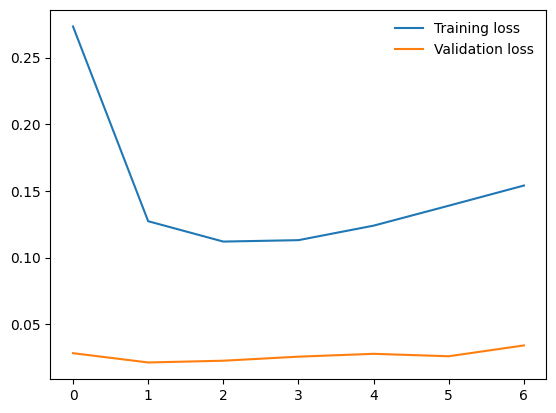

In [80]:
plot_loss(train_losses10, valid_losses10)

In [81]:
#Train Accuracy
model_accuracy(model10, train_loader, dataset='train')

Train Accuracy: 96.49%


In [82]:
#Test Accuracy
model_accuracy(model10, test_loader, dataset='test')

Test Accuracy: 95.97%


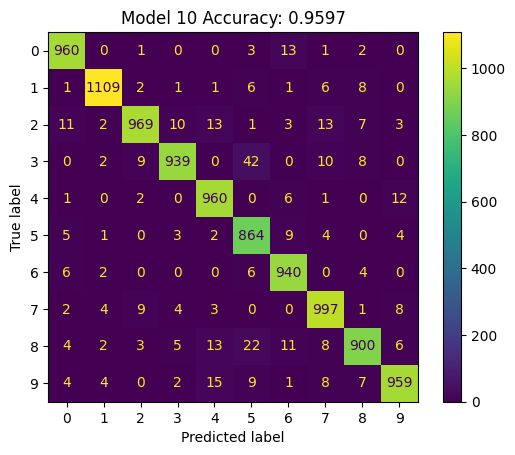

In [83]:
plot_confusion_matrix(model10, test_loader, 10)

In [84]:
model10_info = save_model_info(model10, 10)
models_info = models_info.append(model10_info, ignore_index=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_41788\2706041602.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_info = models_info.append(model10_info, ignore_index=True)
C:\Users\thele\AppData\Local\Temp\ipykernel_41788\2706041602.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  models_info = models_info.append(model10_info, ignore_index=True)


## Model Comparison

In [85]:
#All models
models_info

,model_num,hidden_layer_sizes,dropout_p,batch_norm,train_time_mins,loss_fn,optimizer,scheduler,test_accuracy,train_accuracy
0,1,"[128, 128]",0.2,False,8.018602,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,None,0.9792,0.990479
1,2,"[128, 128]",0.2,False,8.443167,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,<torch.optim.lr_scheduler.StepLR object at 0x0...,0.9588,0.961208
2,3,"[128, 128]",0.2,False,5.207216,CrossEntropyLoss(),SGD (\nParameter Group 0\n base_momentum: 0...,<torch.optim.lr_scheduler.OneCycleLR object at...,0.9808,0.995104
3,4,"[128, 128]",0.0,True,3.576176,CrossEntropyLoss(),SGD (\nParameter Group 0\n base_momentum: 0...,<torch.optim.lr_scheduler.OneCycleLR object at...,0.9807,0.999313
4,5,"[128, 128, 64]",0.2,False,8.652956,CrossEntropyLoss(),SGD (\nParameter Group 0\n base_momentum: 0...,<torch.optim.lr_scheduler.OneCycleLR object at...,0.9836,0.998167
5,6,"[512, 512]",0.2,False,5.902657,CrossEntropyLoss(),SGD (\nParameter Group 0\n base_momentum: 0...,<torch.optim.lr_scheduler.OneCycleLR object at...,0.9846,0.998000
6,7,"[128, 128, 128, 64, 64]",0.2,False,5.982006,CrossEntropyLoss(),SGD (\nParameter Group 0\n base_momentum: 0...,<torch.optim.lr_scheduler.OneCycleLR object at...,0.9792,0.992625
7,8,"[512, 512]",0.5,False,11.952056,CrossEntropyLoss(),SGD (\nParameter Group 0\n base_momentum: 0...,<torch.optim.lr_scheduler.OneCycleLR object at...,0.9824,0.992917
8,9,"[512, 512]",0.2,False,7.136277,CrossEntropyLoss(),SGD (\nParameter Group 0\n base_momentum: 0...,<torch.optim.lr_scheduler.OneCycleLR object at...,0.9615,0.964333
9,10,"[512, 512]",0.2,False,2.294251,CrossEntropyLoss(),Adam (\nParameter Group 0\n amsgrad: False\...,<torch.optim.lr_scheduler.OneCycleLR object at...,0.9597,0.964854


In [86]:
#All models sorted by test accuracy
models_info[['model_num', 'hidden_layer_sizes', 'train_accuracy', 'test_accuracy']].sort_values('test_accuracy', ascending=False)

,model_num,hidden_layer_sizes,train_accuracy,test_accuracy
5,6,"[512, 512]",0.998000,0.9846
4,5,"[128, 128, 64]",0.998167,0.9836
7,8,"[512, 512]",0.992917,0.9824
2,3,"[128, 128]",0.995104,0.9808
3,4,"[128, 128]",0.999313,0.9807
0,1,"[128, 128]",0.990479,0.9792
6,7,"[128, 128, 128, 64, 64]",0.992625,0.9792
8,9,"[512, 512]",0.964333,0.9615
9,10,"[512, 512]",0.964854,0.9597
1,2,"[128, 128]",0.961208,0.9588
